In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from pandas_datareader import data as pdr
import fix_yahoo_finance as yf
from collections import deque
from datetime import datetime
import random
import tensorflow.compat.v1 as tf
import sys
tf.compat.v1.disable_eager_execution()

/home/armat/.local/lib/python3.8/site-packages/fix_yahoo_finance/__init__.py:0: DeprecationWarning: 

*** `fix_yahoo_finance` was renamed to `yfinance`. ***
Please install and use `yfinance` directly using `pip install yfinance -U`

More information: https://github.com/ranaroussi/yfinance



In [ ]:
# yf.pdr_override()
df_full = yf.download("INFY", start="2018-01-01")
df_full.to_csv('INFY.csv',index=False)
df_full.head()

In [ ]:
df= df_full.copy()
name = 'Q-Learning Agent'
class Agent:
    def __init__(self, state_size, window_size, trend, skip, batch_size):
        self.state_size = state_size
        self.window_size = window_size
        self.half_window = window_size // 2
        self.trend = trend
        self.skip = skip
        self.action_size = 3
        self.batch_size = batch_size
        self.memory = deque(maxlen = 1000) # Replay memory to store previous expreinces
        self.inventory = []
        self.gamma = 0.95
        self.epsilon = 0.5
        self.epsilon_min = 0.01
        self.epsilon_max = 1.00
        self.epsilon_decay = 0.999
        tf.reset_default_graph()
        self.sess = tf.InteractiveSession()
        self.X = tf.placeholder(tf.float32, [None, self.state_size])
        self.Y = tf.placeholder(tf.float32, [None, self.action_size])
        feed = tf.layers.dense(self.X, 256, activation = tf.nn.relu)
        self.logits = tf.layers.dense(feed, self.action_size)
        self.cost = tf.reduce_mean(tf.square(self.Y - self.logits))
        self.optimizer = tf.train.GradientDescentOptimizer(1e-5).minimize(
            self.cost
        )
        self.sess.run(tf.global_variables_initializer())

    # Function that returns the state
    def act(self, state):
        if random.random() <= self.epsilon:
            return random.randrange(self.action_size)
        # print(state.shape, "Hello")
        return np.argmax(
            # Runs the forward propagation step in neural network and returns the actions corresponding to the max q value for the provided state
            self.sess.run(self.logits, feed_dict = {self.X: state})[0]
        )

    def get_state(self, t):
        print(t)
        exit(0)
        window_size = self.window_size + 1
        d = t - window_size + 1
        block = self.trend[d : t + 1] if d >= 0 else -d * [self.trend[0]] + self.trend[0 : t + 1]
        res = []
        for i in range(window_size - 1):
            res.append(block[i + 1] - block[i])
        return np.array([res])

    def replay(self, batch_size):
        mini_batch = []
        l = len(self.memory)
        for i in range(l - batch_size, l):
            mini_batch.append(self.memory[i])
        replay_size = len(mini_batch)
        X = np.empty((replay_size, self.state_size))
        Y = np.empty((replay_size, self.action_size))

        # print((mini_batch[0][0]), (mini_batch[0][0].shape) , "Hihih")
        # sys.exit(0)
        states = np.array([a[0][0] for a in mini_batch])
        new_states = np.array([a[3][0] for a in mini_batch])
        
        Q = self.sess.run(self.logits, feed_dict = {self.X: states})
        Q_new = self.sess.run(self.logits, feed_dict = {self.X: new_states})
        for i in range(len(mini_batch)):
            state, action, reward, next_state, done = mini_batch[i]
            target = Q[i]
            target[action] = reward
            if not done:
                target[action] += self.gamma * np.amax(Q_new[i])
            X[i] = state
            Y[i] = target

        # BACK PROPAGATION
        cost, _ = self.sess.run(
            [self.cost, self.optimizer], feed_dict = {self.X: X, self.Y: Y}
        )
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
        
        return cost
    def buy(self, initial_money):
        starting_money = initial_money
        states_sell = []
        states_buy = []
        inventory = []
        state = self.get_state(0)
        for t in range(0, len(self.trend) - 1, self.skip):
            action = self.act(state)
            next_state = self.get_state(t + 1)
            if action == 1 and initial_money >= self.trend[t] and t < (len(self.trend) - self.half_window):
                inventory.append(self.trend[t])
                initial_money -= self.trend[t]
                states_buy.append(t)
                print('day %d: buy 1 unit at price %f, total balance %f'% (t, self.trend[t], initial_money))
            elif action == 2 and len(inventory):
                bought_price = inventory.pop(0)
                initial_money += self.trend[t]
                states_sell.append(t)
                try:
                    invest = ((close[t] - bought_price) / bought_price) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell 1 unit at price %f, investment %f %%, total balance %f,'
                    % (t, close[t], invest, initial_money)
                )
            state = next_state
        invest = ((initial_money - starting_money) / starting_money) * 100
        total_gains = initial_money - starting_money
        return states_buy, states_sell, total_gains, invest
    def train(self, iterations, checkpoint, initial_money):
        for i in range(iterations):
            total_profit = 0
            inventory = []
            state = self.get_state(0)
            starting_money = initial_money
            for t in range(0, len(self.trend) - 1, self.skip):
                action = self.act(state)
                next_state = self.get_state(t + 1)
                if action == 1 and starting_money >= self.trend[t] and t < (len(self.trend) - self.half_window):
                    inventory.append(self.trend[t])
                    starting_money -= self.trend[t]
                elif action == 2 and len(inventory) > 0:
                    bought_price = inventory.pop(0)
                    total_profit += self.trend[t] - bought_price
                    starting_money += self.trend[t]
                invest = ((starting_money - initial_money) / initial_money)
                self.memory.append((state, action, invest, 
                                    next_state, starting_money < initial_money))
                state = next_state
                batch_size = min(self.batch_size, len(self.memory))
                cost = self.replay(batch_size)
            if (i+1) % checkpoint == 0:
                print('epoch: %d, total rewards: %f.3, cost: %f, total money: %f'%(i + 1, total_profit, cost,
                                                                                  starting_money))

In [ ]:
close = df.Close.values.tolist()
initial_money = 10000
window_size = 30
skip = 1
batch_size = 32
agent = Agent(state_size = window_size,
              window_size = window_size,
              trend = close,
              skip = skip,
              batch_size = batch_size)
agent.train(iterations = 200, checkpoint = 10, initial_money = initial_money)

/home/armat/.local/lib/python3.8/site-packages/tensorflow/python/client/session.py:1769: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
<ipython-input-5-662ebb246d79>:23: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  feed = tf.layers.dense(self.X, 256, activation = tf.nn.relu)
<ipython-input-5-662ebb246d79>:24: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  self.logits = tf.layers.dense(feed, self.action_size)


epoch: 10, total rewards: 3.605013.3, cost: 0.005565, total money: 10003.605013
epoch: 20, total rewards: 4.270011.3, cost: 0.005516, total money: 10004.270011
epoch: 30, total rewards: 2.360016.3, cost: 0.005470, total money: 10002.360016
epoch: 40, total rewards: 0.595017.3, cost: 0.005431, total money: 10000.595017
epoch: 50, total rewards: 1.120014.3, cost: 0.005393, total money: 10001.120014
epoch: 60, total rewards: 3.100014.3, cost: 0.005354, total money: 10003.100014
epoch: 70, total rewards: 2.385011.3, cost: 0.005323, total money: 10002.385011
epoch: 80, total rewards: -0.479984.3, cost: 0.009144, total money: 9999.520016
epoch: 90, total rewards: 0.325013.3, cost: 0.005257, total money: 10000.325013
epoch: 100, total rewards: 0.745013.3, cost: 0.005226, total money: 10000.745013
epoch: 110, total rewards: 1.470011.3, cost: 0.005195, total money: 10001.470011
epoch: 120, total rewards: 0.855012.3, cost: 0.005171, total money: 10000.855012
epoch: 130, total rewards: -1.624988.

In [ ]:
initial_money = 100000
states_buy, states_sell, total_gains, invest = agent.buy(initial_money = initial_money)

day 7: buy 1 unit at price 8.635000, total balance 99991.365000
day 9: buy 1 unit at price 8.890000, total balance 99982.474999
day 10, sell 1 unit at price 9.060000, investment 4.921832 %, total balance 99991.535000,
day 11, sell 1 unit at price 8.960000, investment 0.787398 %, total balance 100000.495000,
day 13: buy 1 unit at price 9.145000, total balance 99991.349999
day 14, sell 1 unit at price 9.225000, investment 0.874794 %, total balance 100000.575000,
day 20: buy 1 unit at price 9.005000, total balance 99991.570000
day 21, sell 1 unit at price 8.965000, investment -0.444197 %, total balance 100000.535000,
day 32: buy 1 unit at price 8.795000, total balance 99991.740000
day 33, sell 1 unit at price 8.820000, investment 0.284248 %, total balance 100000.559999,
day 43: buy 1 unit at price 8.995000, total balance 99991.565000
day 44, sell 1 unit at price 8.945000, investment -0.555866 %, total balance 100000.509999,
day 45: buy 1 unit at price 9.015000, total balance 99991.494999


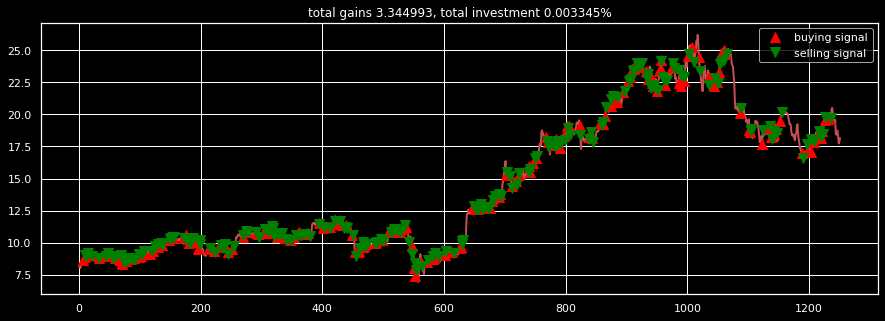

In [ ]:
fig = plt.figure(figsize = (15,5))
plt.style.use('dark_background')
plt.plot(close, color='r', lw=2.)
plt.plot(close, '^', markersize=10, color='red', label = 'buying signal', markevery = states_buy)
plt.plot(close, 'v', markersize=10, color='green', label = 'selling signal', markevery = states_sell)
plt.title('total gains %f, total investment %f%%'%(total_gains, invest))
plt.legend()
plt.savefig(name+'.png')
plt.show()